In [1]:

## Dynamic Time Warping If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
# import sys
#!{sys.executable} -m pip install fastdtw

#See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

In [2]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # xSquared = np.multiply(self.x , self.x)
        # ySquared = np.multiply(self.y, self.y)
        # zSquared = np.multiply(self.z, self.z)
        # self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        # Fixed April 26, 2018 based on class comment by Krzysztof D.
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [3]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        print ("This is the ###", gestureTrialNum)
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [4]:
# Load the given data

# You should change the path to the location of the log files on your system
# logPath = '/Users/jonf/Dropbox/CSE590_UbiComp/Git/CSE590Sp2018p/A02-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\CSE590_UbiComp\Git\CSE590Sp2018\A02-GestureRecognizer\JonGestureLogs"

logPath = './JonGestureLogs'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
This is the ### 5
Found 5 trials for 'Backhand Tennis'
This is the ### 5
Found 5 trials for 'Midair Clockwise O'
This is the ### 5
Found 5 trials for 'At Rest'
This is the ### 5
Found 5 trials for 'Midair Zorro Z'
This is the ### 5
Found 5 trials for 'Shake'
This is the ### 5
Found 5 trials for 'Underhand Bowling'
This is the ### 5
Found 5 trials for 'Midair S'
This is the ### 5
Found 5 trials for 'Midair Counter Clockwise O'
This is the ### 5
Found 5 trials for 'Baseball Throw'
This is the ### 5
Found 5 trials for 'Forehand Tennis'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match


In [5]:
# Load my data

mylogPath = './MyGestureData'
mymapGestureToTrials = parse_and_create_gesture_trials(mylogPath)
cuslogPath = "./customizeGestureData"
cusmapGestureToTrials = parse_and_create_gesture_trials(cuslogPath)
alllogPath="./AllMyGestureData"
allmymapGestureToTrials = parse_and_create_gesture_trials(alllogPath)

Found 100 csv files in ./MyGestureData
Found 10 gestures
This is the ### 5
Found 5 trials for 'Forehand Tennis'
This is the ### 5
Found 5 trials for 'Midair Zorro Z'
This is the ### 5
Found 5 trials for 'Midair Counter Clockwise O'
This is the ### 5
Found 5 trials for 'Midair S'
This is the ### 5
Found 5 trials for 'At Rest'
This is the ### 5
Found 5 trials for 'Backhand Tennis'
This is the ### 5
Found 5 trials for 'Baseball Throw'
This is the ### 5
Found 5 trials for 'Midair Clockwise O'
This is the ### 5
Found 5 trials for 'Underhand Bowling'
This is the ### 5
Found 5 trials for 'Shake'
Max trial length across all gesture is 'Midair Counter Clockwise O' Trial 1 with 203 sensor events. Resizing all arrays to match
Found 10 csv files in ./customizeGestureData
Found 1 gestures
This is the ### 5
Found 5 trials for 'Your Custom Gesture'
Max trial length across all gesture is 'Your Custom Gesture' Trial 4 with 119 sensor events. Resizing all arrays to match
Found 110 csv files in ./AllMyGe

Text(0.5,0,'time (ms)')

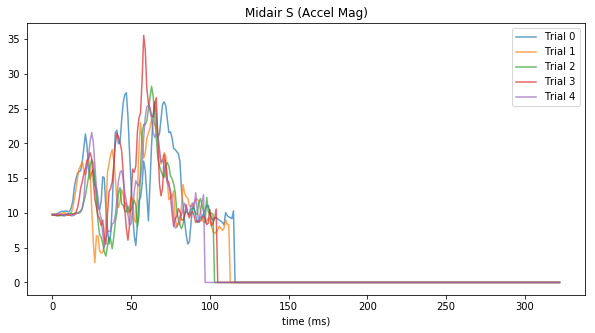

In [6]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()
plt.xlabel('time (ms)')

Text(0.5,0,'time (ms)')

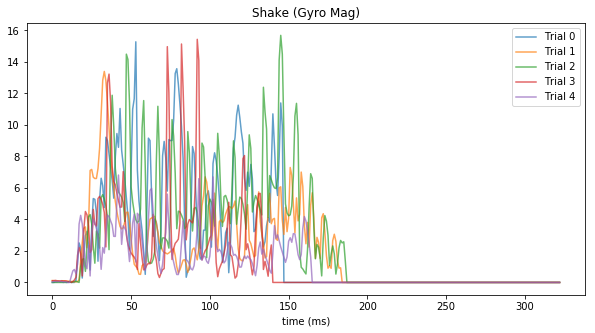

In [7]:
# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Gyro Mag)")
axes.legend()
plt.xlabel('time (ms)')



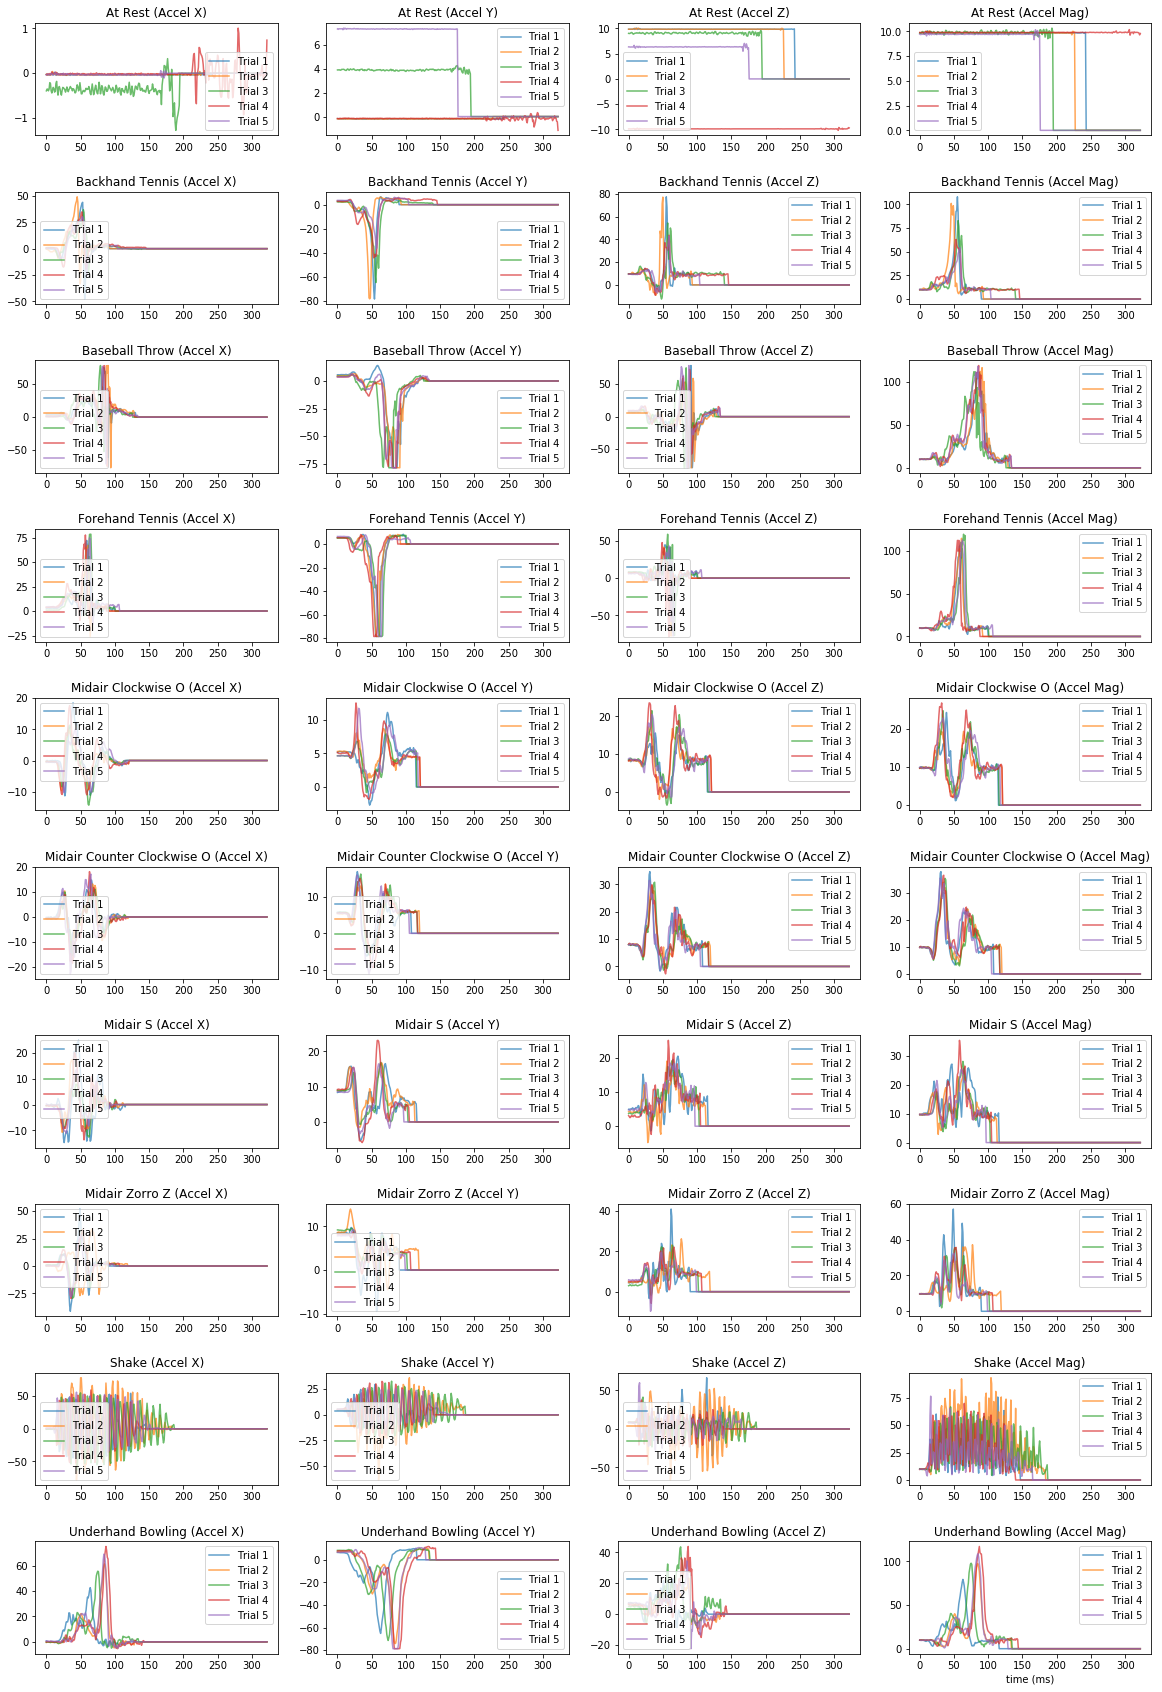

In [8]:
# Now let's plot all of the given accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

    
index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    plt.xlabel('time (ms)')
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    
    index = index + 1
    
   


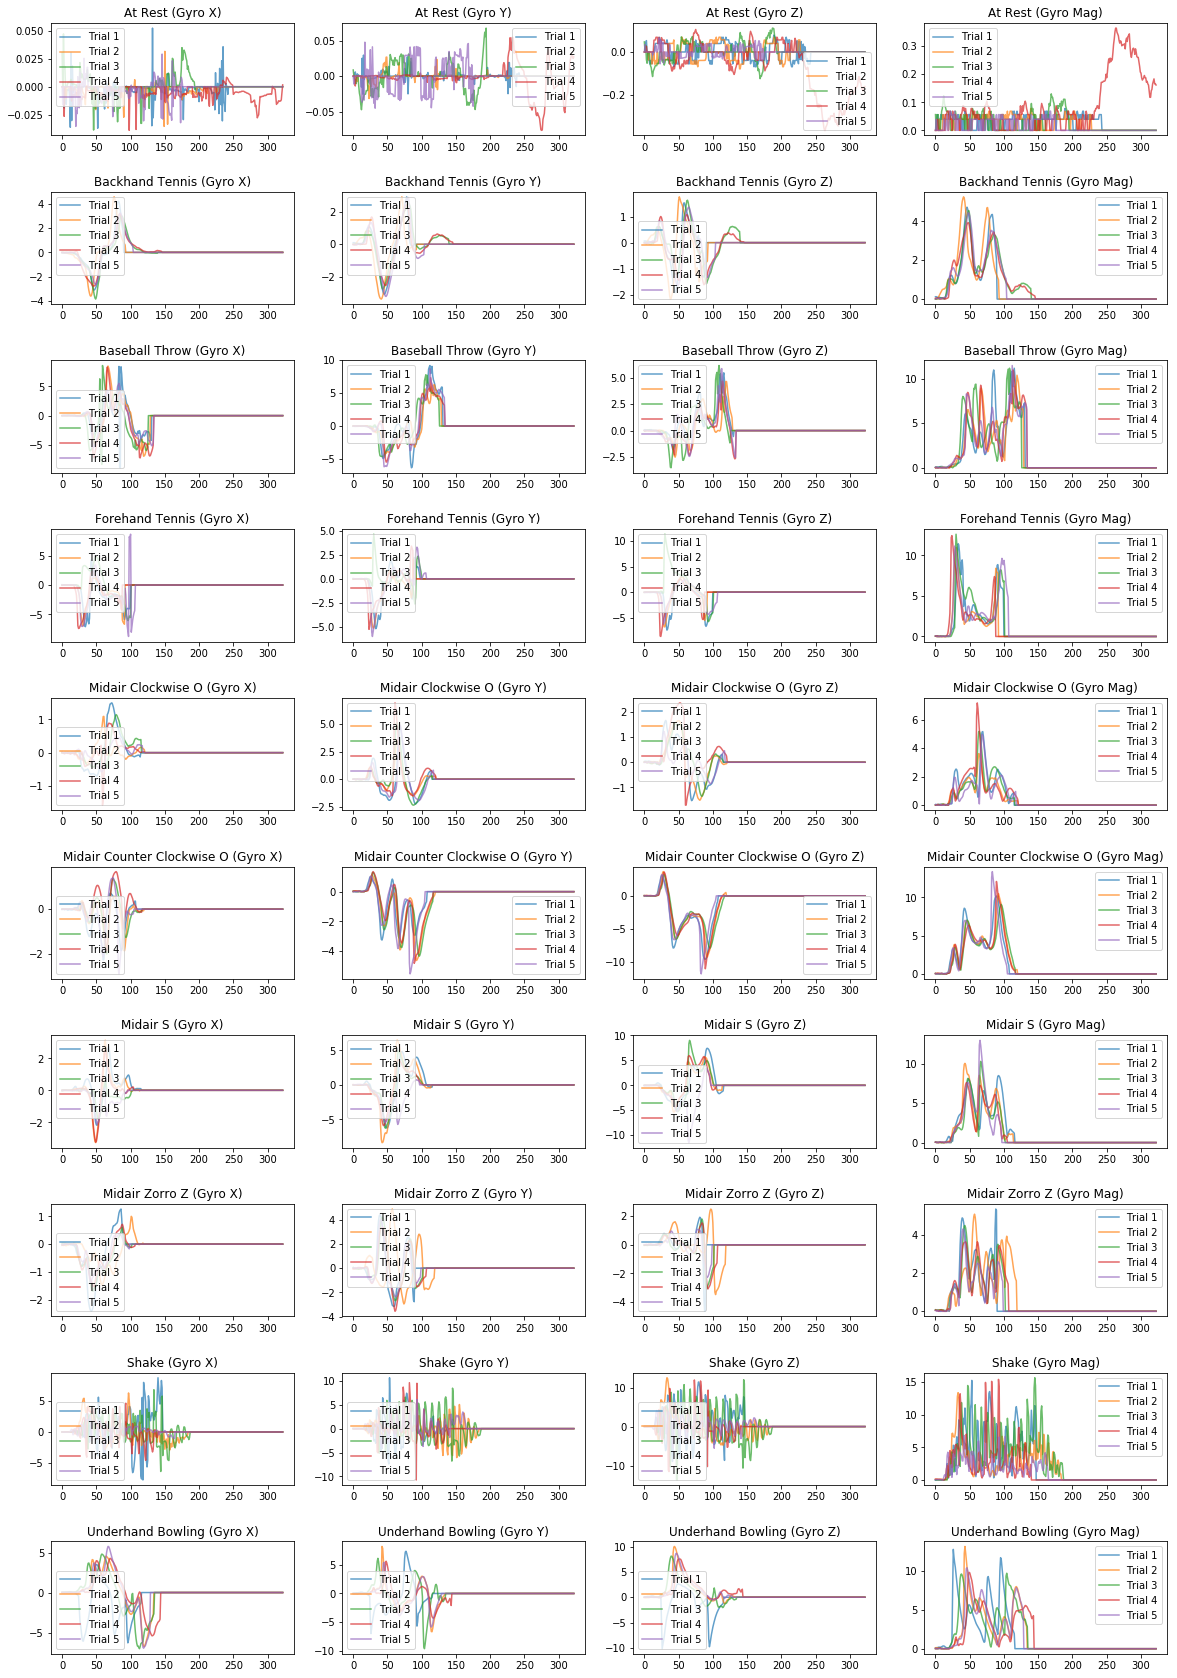

In [9]:
# Now let's plot all of the given gyro signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Gyro X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Gyro Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Gyro Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Gyro Mag)")
    axes[index][3].legend()
    index = index + 1

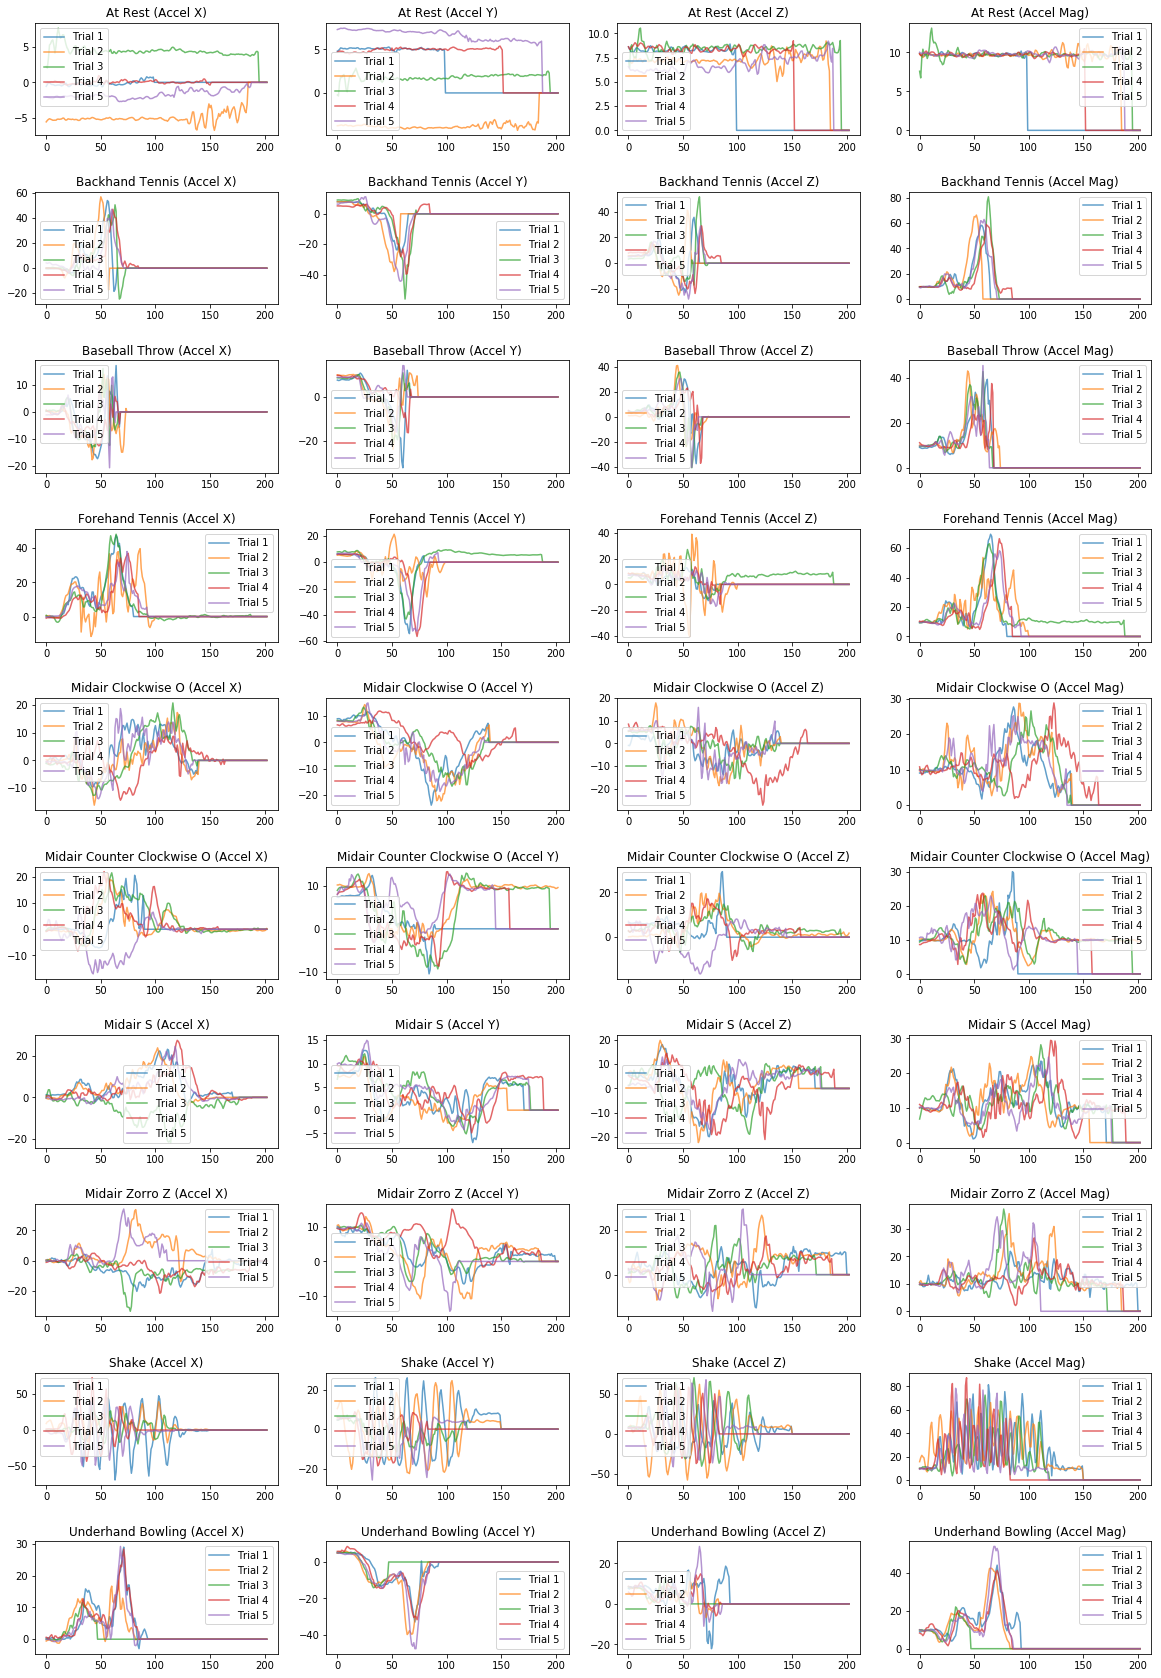

In [10]:
# Now let's plot all of your own accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mymapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mymapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1



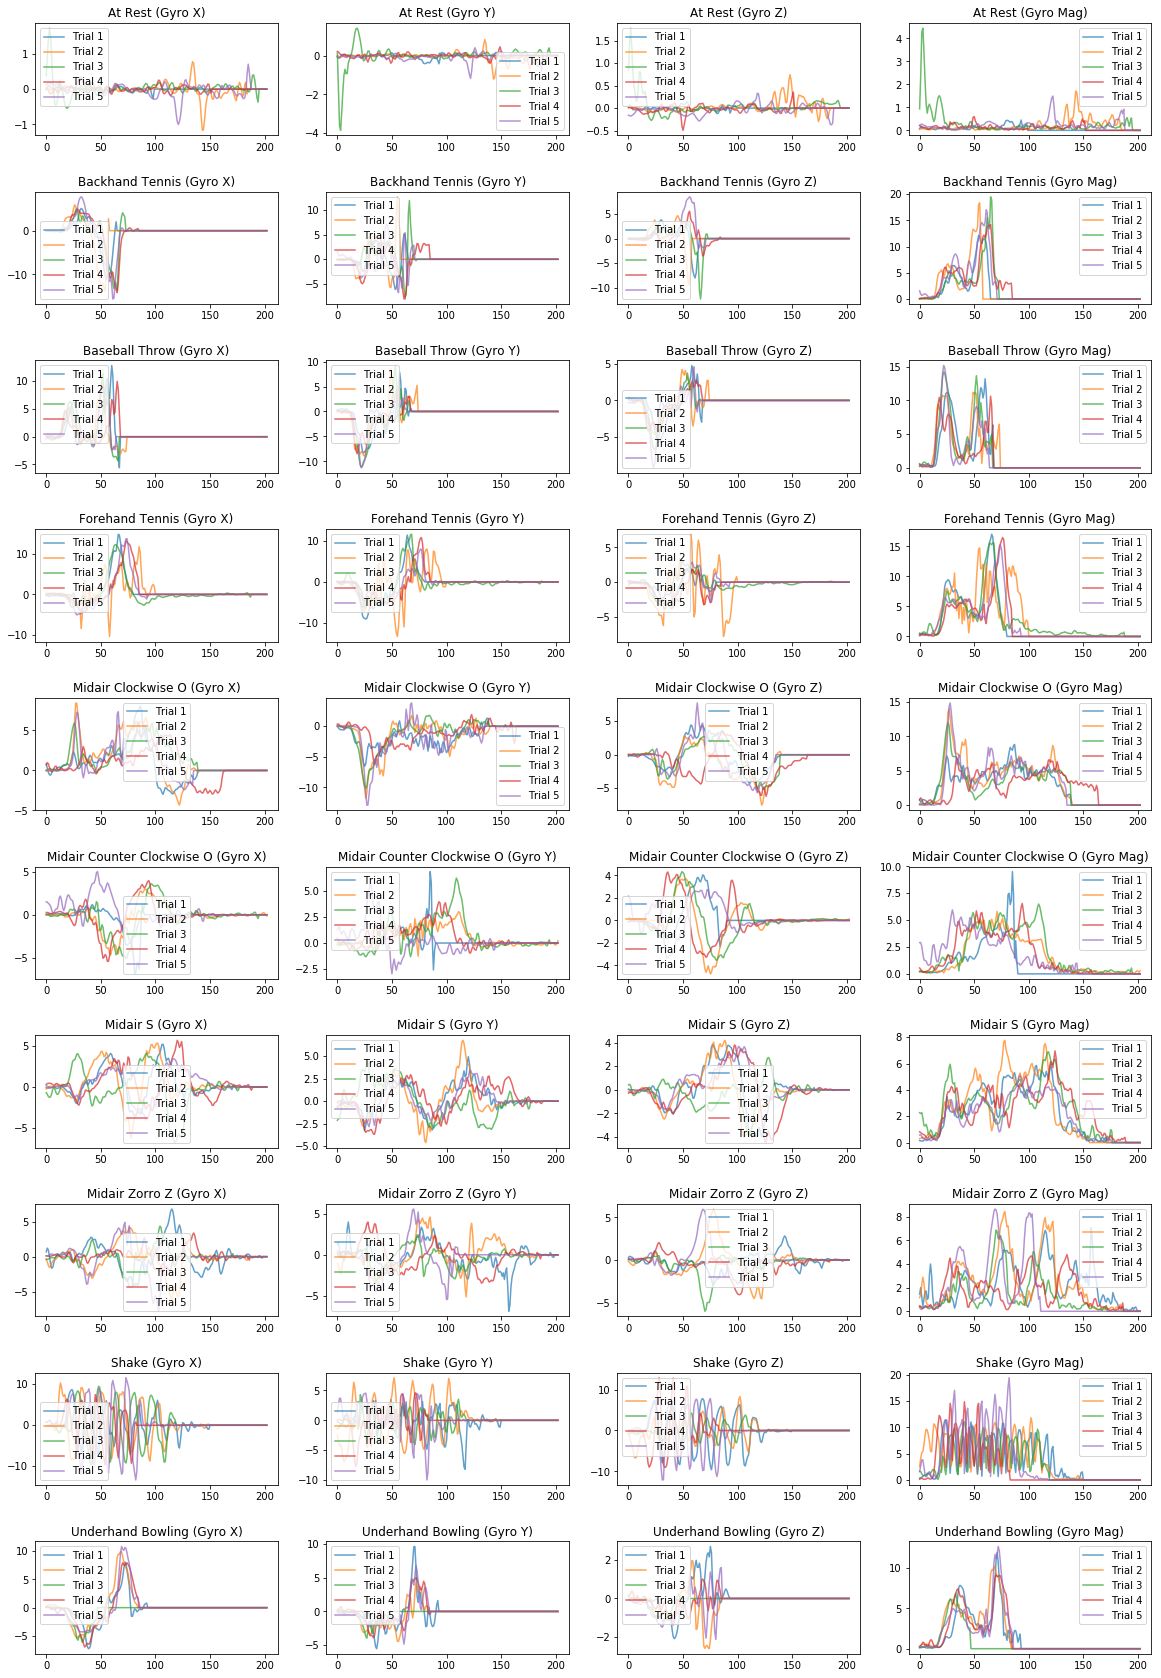

In [11]:
# Now let's plot all of your own gyro signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mymapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mymapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Gyro X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Gyro Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Gyro Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Gyro Mag)")
    axes[index][3].legend()
    index = index + 1

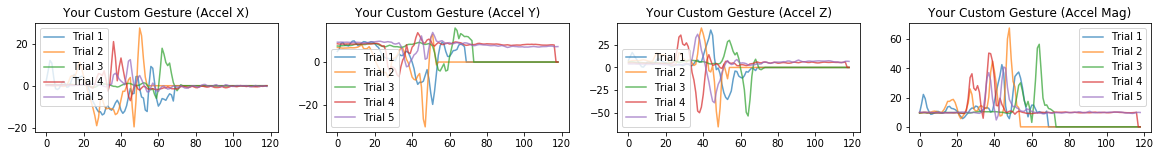

In [12]:
# Now let's plot customize accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(cusmapGestureToTrials), 4, figsize=(20, 2 * len(cusmapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(cusmapGestureToTrials.keys())

for gestureName in gestureNamesSorted:
    gestureTrials = cusmapGestureToTrials[gestureName]

    trialNum = 1
    for trial in gestureTrials:
        axes[0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1

    axes[0].set_title(gestureName + " (Accel X)")
    axes[0].legend()

    axes[1].set_title(gestureName + " (Accel Y)")
    axes[1].legend()

    axes[2].set_title(gestureName + " (Accel Z)")
    axes[2].legend()

    axes[3].set_title(gestureName + " (Accel Mag)")
    axes[3].legend()
    index = index + 1





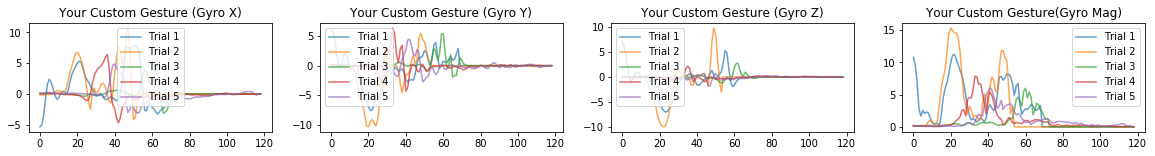

In [13]:
# Now let's plot customize gyro signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(cusmapGestureToTrials), 4, figsize=(20, 2 * len(cusmapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(cusmapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = cusmapGestureToTrials[gestureName]

    trialNum = 1
    for trial in gestureTrials:
        axes[0].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[2].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[3].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1

    axes[0].set_title(gestureName + " (Gyro X)")
    axes[0].legend()

    axes[1].set_title(gestureName + " (Gyro Y)")
    axes[1].legend()

    axes[2].set_title(gestureName + " (Gyro Z)")
    axes[2].legend()

    axes[3].set_title(gestureName + "(Gyro Mag)")
    axes[3].legend()
    index = index + 1

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


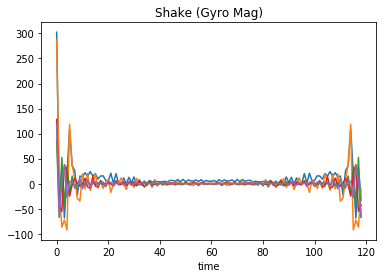

In [14]:
## fft transform signal
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

for trial in gestureTrials:
    transy=np.fft.fft(trial.gyro.mag)  
    
    plt.plot(transy),plt.title(randomGestureName + " (Gyro Mag)"), plt.xlabel("time")
    trialNum = trialNum + 1




/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


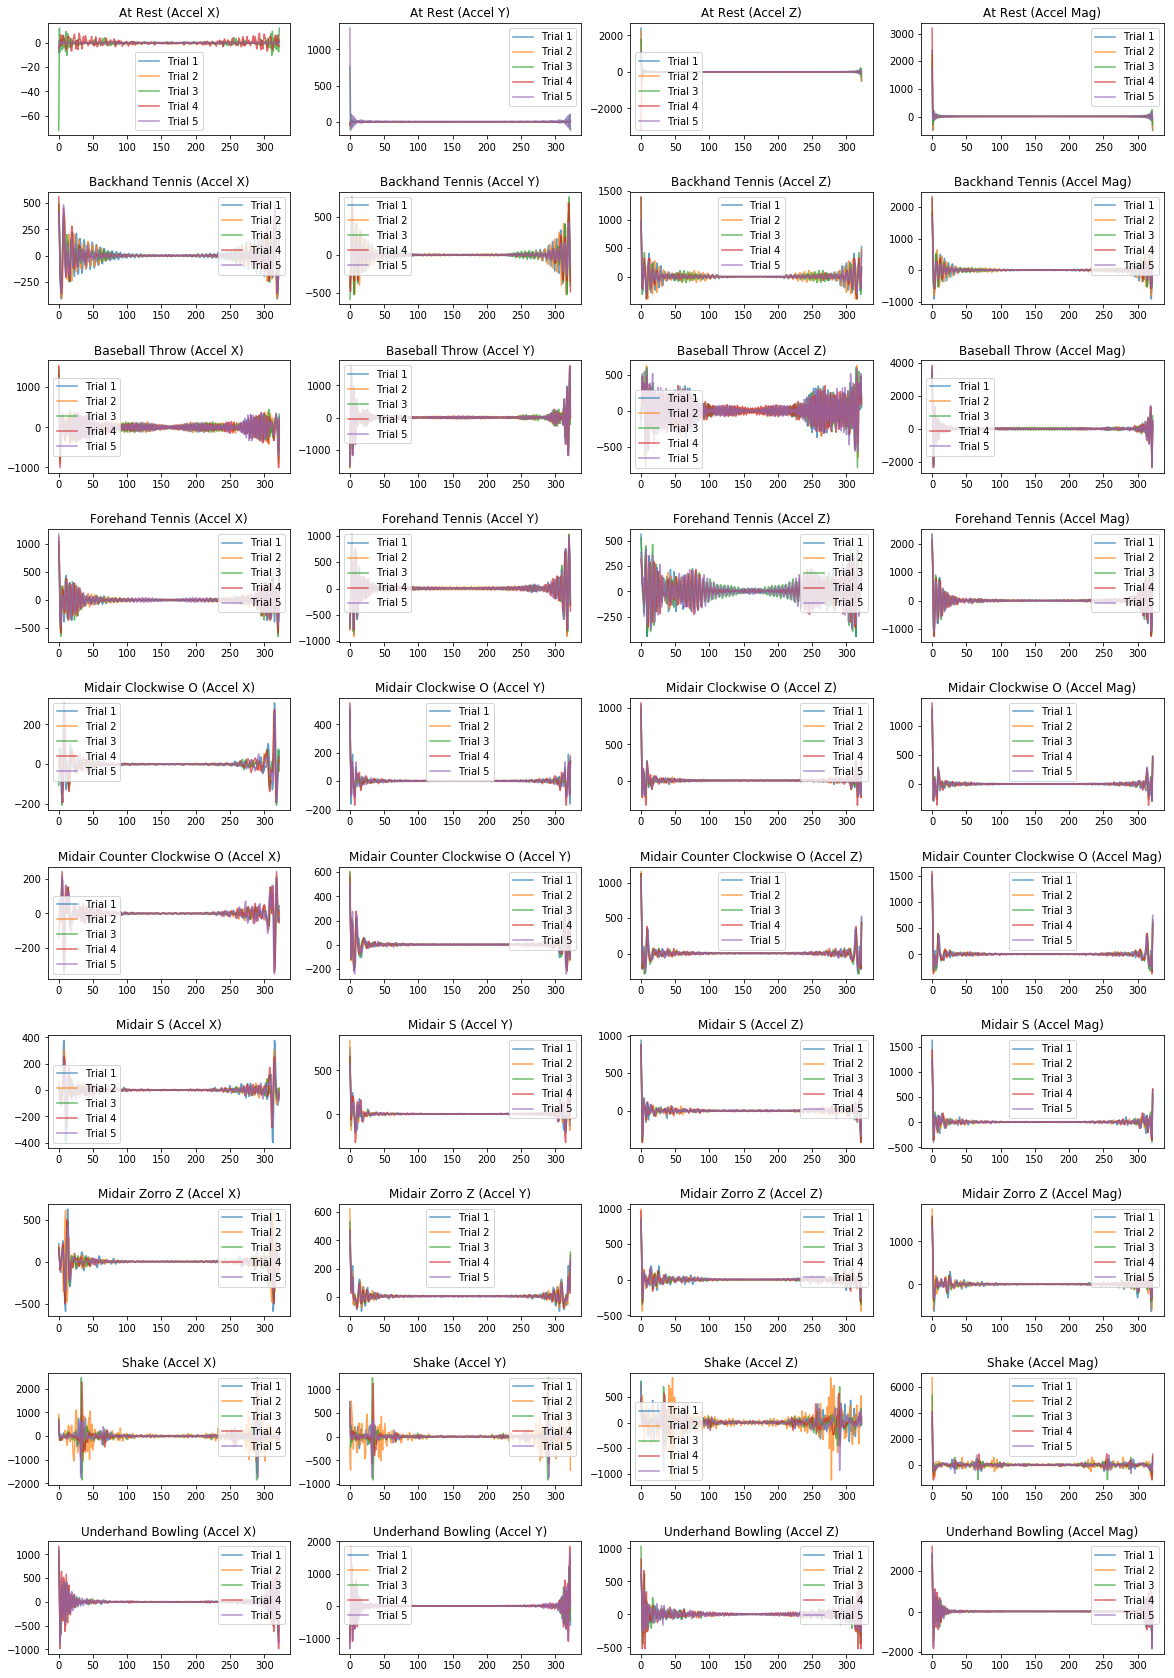

In [15]:
## fft transform accel signal for given dataset

fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(np.fft.fft(trial.accel.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(np.fft.fft(trial.accel.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(np.fft.fft(trial.accel.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(np.fft.fft(trial.accel.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1
    
    

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


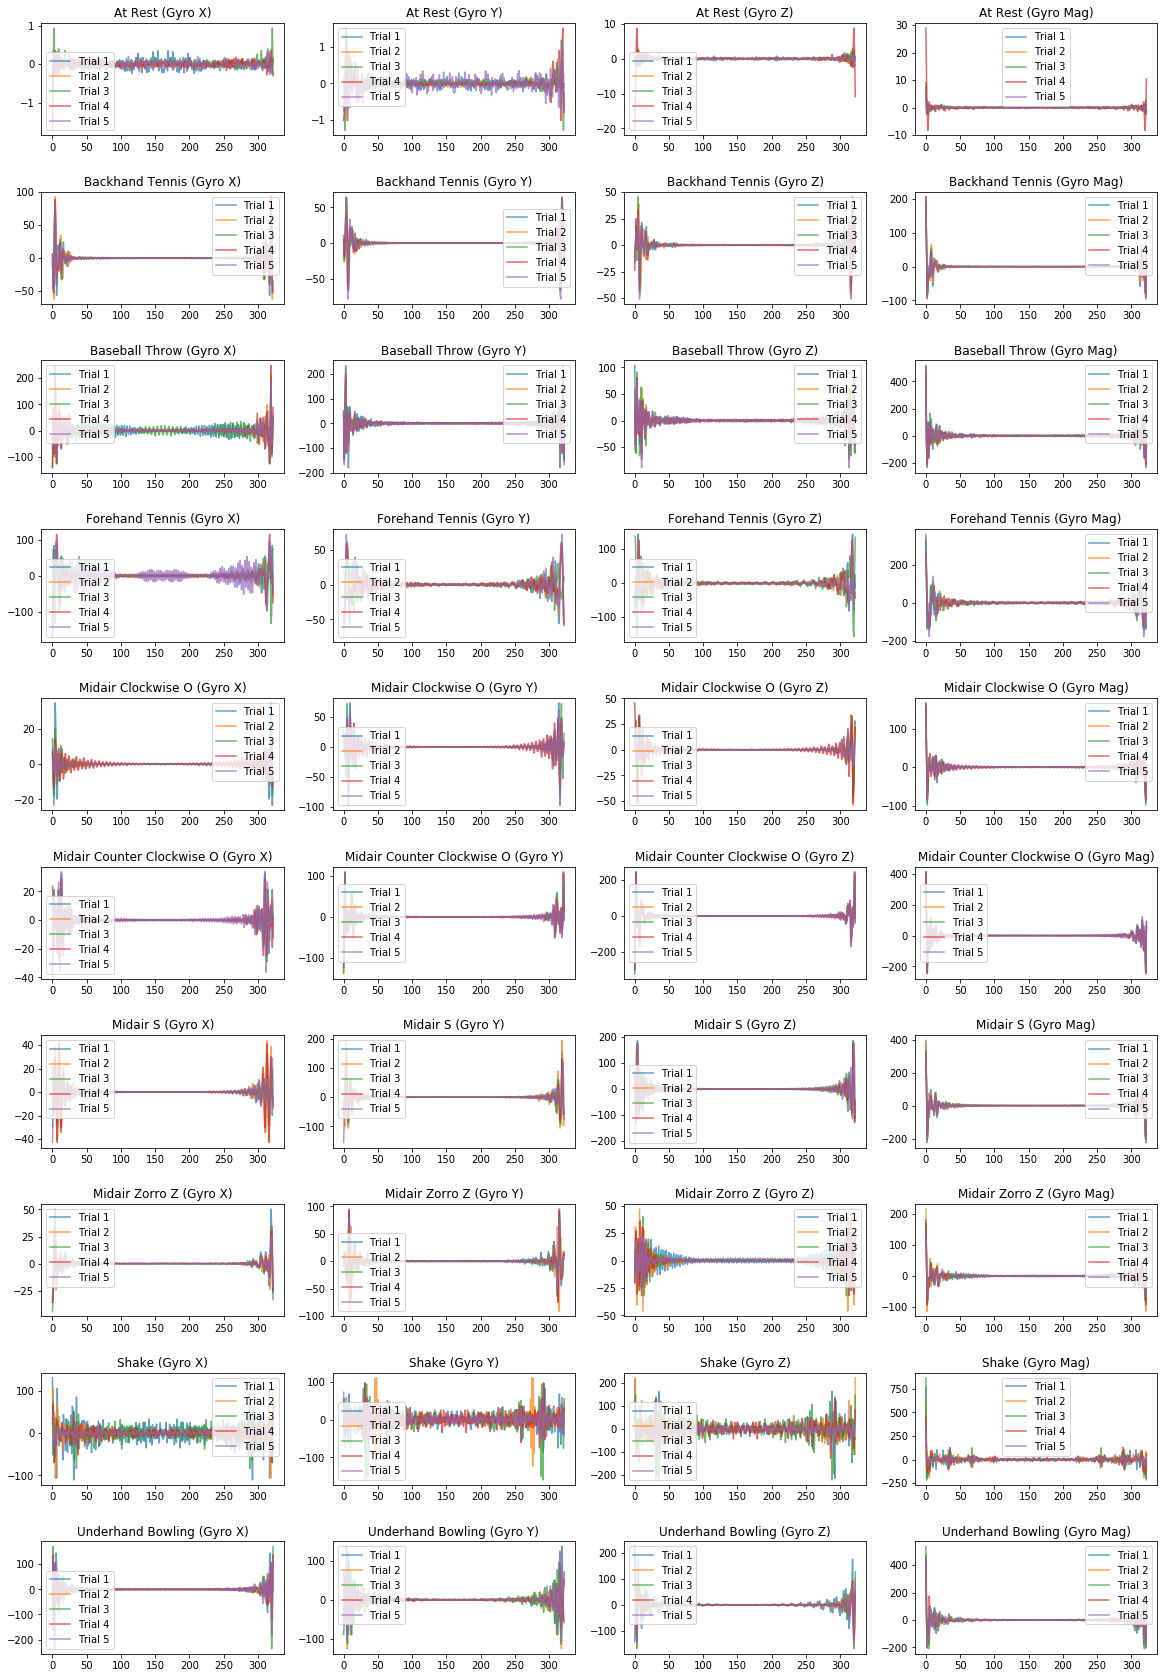

In [16]:
## fft transform gyro signal for given dataset

fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(np.fft.fft(trial.gyro.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(np.fft.fft(trial.gyro.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(np.fft.fft(trial.gyro.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(np.fft.fft(trial.gyro.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Gyro X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Gyro Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Gyro Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Gyro Mag)")
    axes[index][3].legend()
    index = index + 1


/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


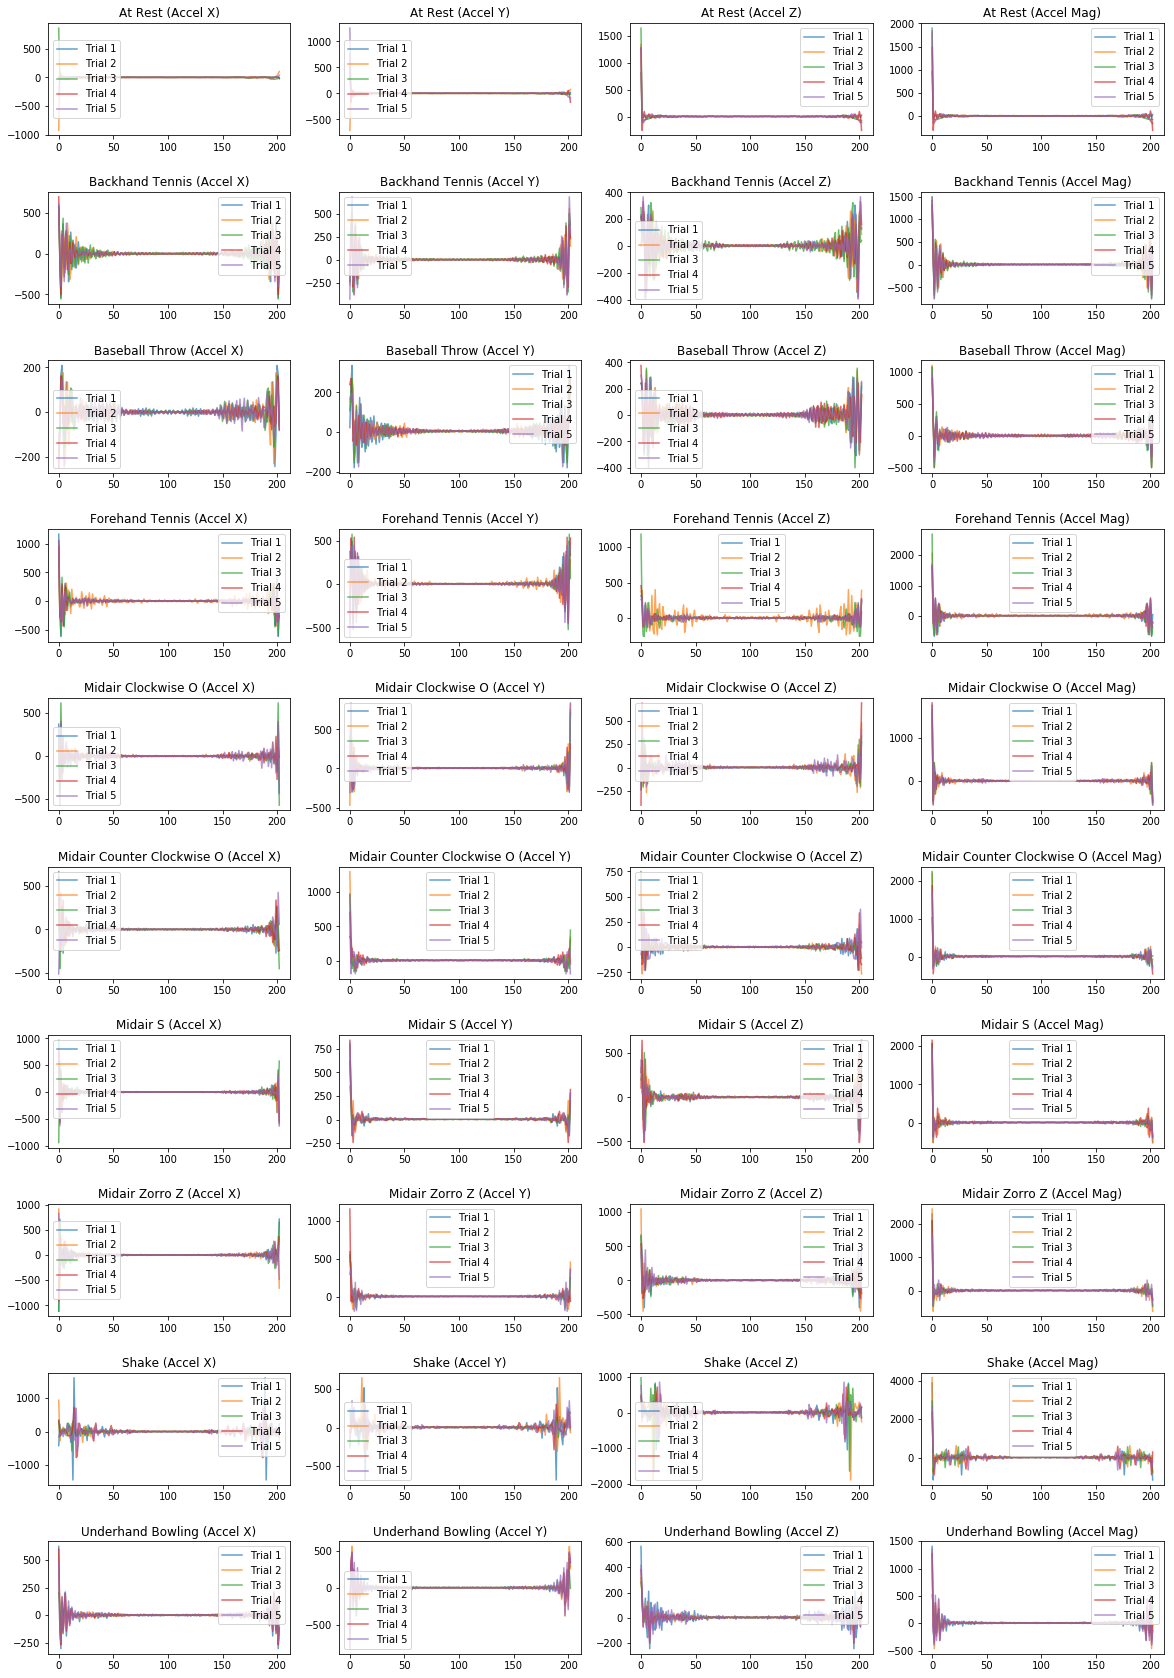

In [17]:
## fft transform accel signal for my dataset

fig, axes = plt.subplots(len(mymapGestureToTrials), 4, figsize=(20, 3 * len(mymapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mymapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mymapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(np.fft.fft(trial.accel.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(np.fft.fft(trial.accel.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(np.fft.fft(trial.accel.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(np.fft.fft(trial.accel.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1
    

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


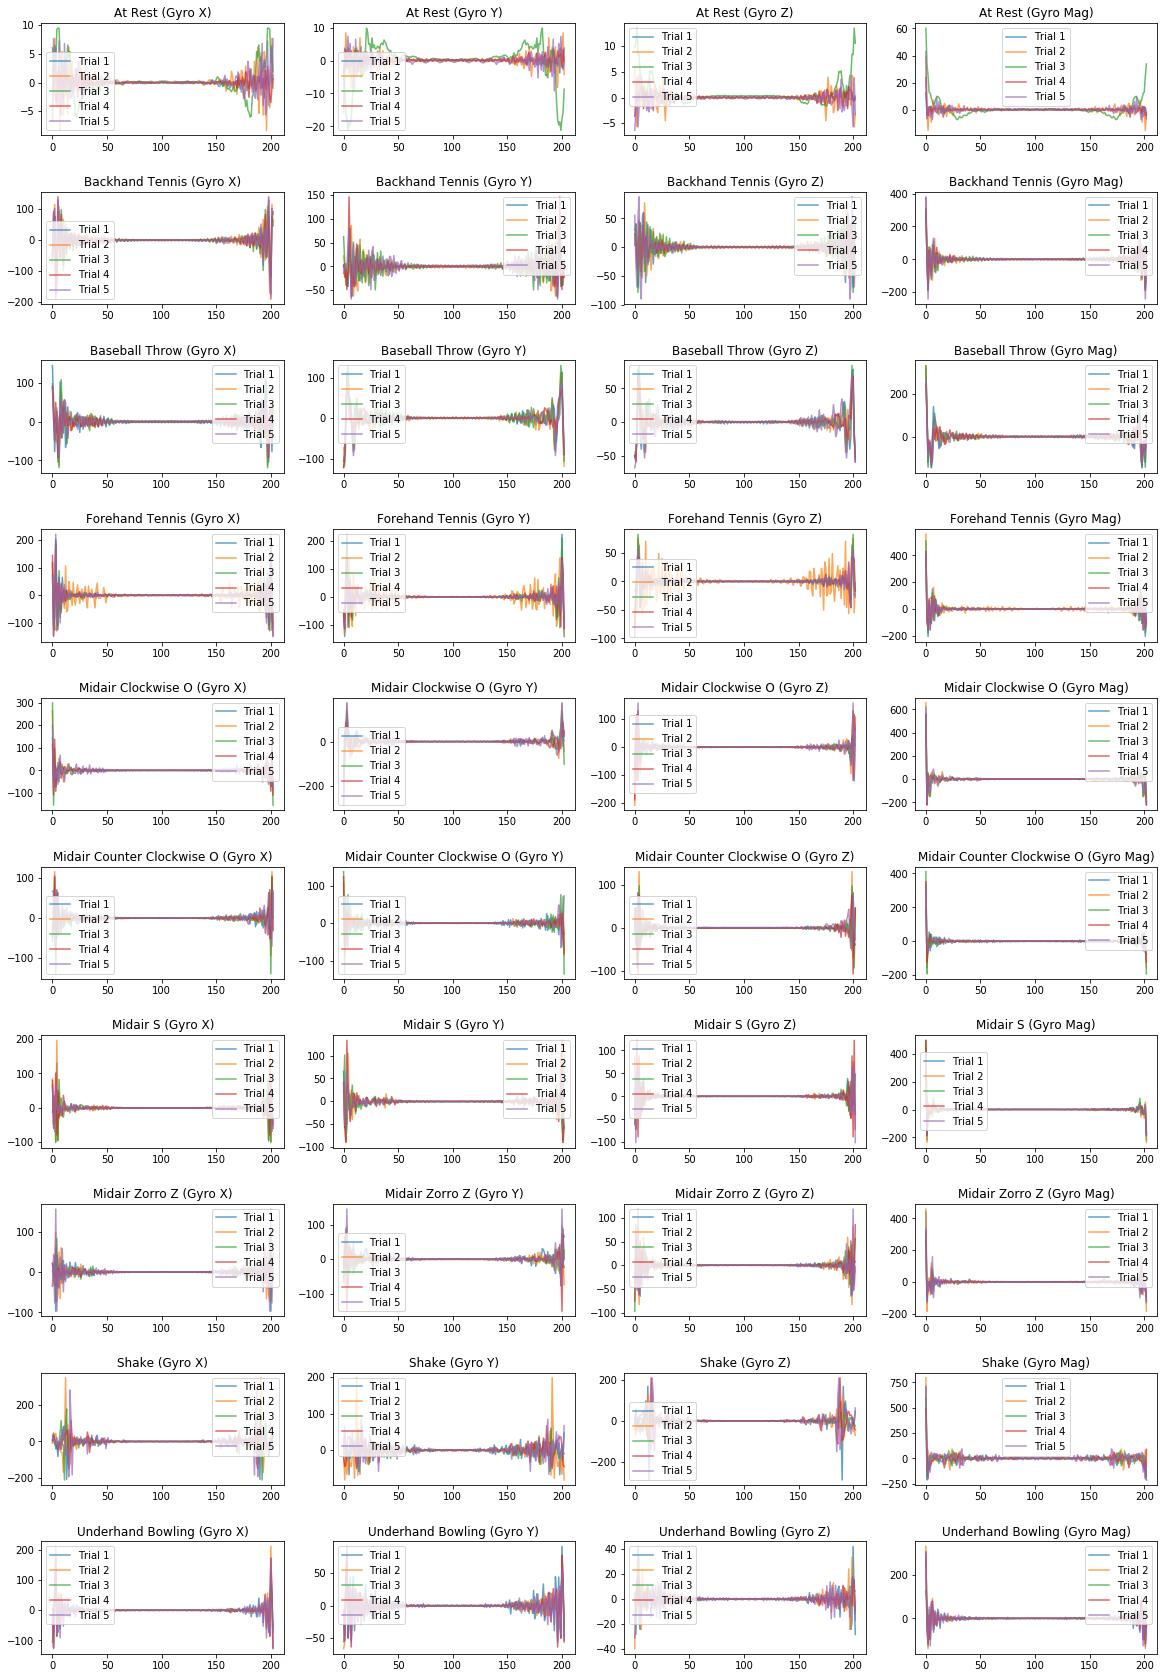

In [18]:
## fft transform gyro signal for my dataset

fig, axes = plt.subplots(len(mymapGestureToTrials), 4, figsize=(20, 3 * len(mymapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mymapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mymapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(np.fft.fft(trial.gyro.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(np.fft.fft(trial.gyro.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(np.fft.fft(trial.gyro.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(np.fft.fft(trial.gyro.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Gyro X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Gyro Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Gyro Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Gyro Mag)")
    axes[index][3].legend()
    index = index + 1
    

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


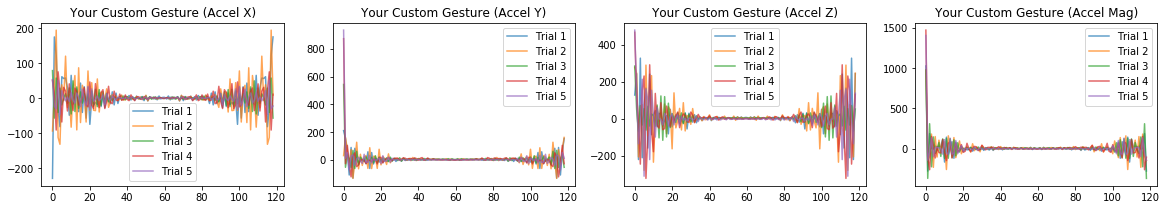

In [19]:
## fft transform accel signal for customized data

fig, axes = plt.subplots(len(cusmapGestureToTrials), 4, figsize=(20, 3 * len(cusmapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(cusmapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = cusmapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[0].plot(np.fft.fft(trial.accel.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[1].plot(np.fft.fft(trial.accel.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[2].plot(np.fft.fft(trial.accel.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[3].plot(np.fft.fft(trial.accel.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[0].set_title(gestureName + " (Accel X)")
    axes[0].legend()
    
    axes[1].set_title(gestureName + " (Accel Y)")
    axes[1].legend()
    
    axes[2].set_title(gestureName + " (Accel Z)")
    axes[2].legend()
    
    axes[3].set_title(gestureName + " (Accel Mag)")
    axes[3].legend()
    index = index + 1
    

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


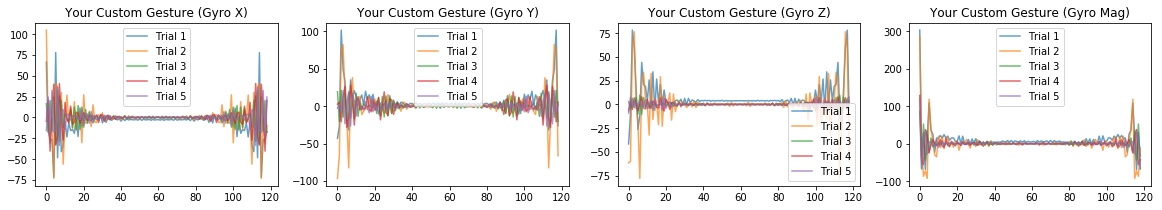

In [20]:
## fft transform gyro signal for customized dataset

fig, axes = plt.subplots(len(cusmapGestureToTrials), 4, figsize=(20, 3 * len(cusmapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(cusmapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = cusmapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[0].plot(np.fft.fft(trial.gyro.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[1].plot(np.fft.fft(trial.gyro.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[2].plot(np.fft.fft(trial.gyro.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[3].plot(np.fft.fft(trial.gyro.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[0].set_title(gestureName + " (Gyro X)")
    axes[0].legend()
    
    axes[1].set_title(gestureName + " (Gyro Y)")
    axes[1].legend()
    
    axes[2].set_title(gestureName + " (Gyro Z)")
    axes[2].legend()
    
    axes[3].set_title(gestureName + " (Gyro Mag)")
    axes[3].legend()
    index = index + 1

# Model-Based ML Exercises
Here is some code for the in-class exercises on Thurs, April 19

In [21]:
# Given the online discussion about k-fold implementations, I thought I would provide my own. Note that sci-kit learn also 
# has built-in functionality for this (I've never used it but worth checking out):
# http://scikit-learn.org/stable/modules/cross_validation.html
from random import randint

# Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial for that fold
# if createNewKFold is True, returns a new random fold, otherwise returns same fold setup as before 
# (this is to better enable repeat experimentation). WARNING: if you are trying to use multiple gesture datasets
# make sure you set createNewKFold=True
fixedFoldsToMapGestureToTrial = None
a = mapGestureToTrials
def generate_kfolds(a, numFolds=5, createNewKFold=True):
    global fixedFoldsToMapGestureToTrial
    
    if createNewKFold is False and fixedFoldsToMapGestureToTrial is not None:
        return fixedFoldsToMapGestureToTrial
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gestureName, trials in a.items():
        if numFolds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(numFolds, gestureName, len(trials)))


    numGestures = len(a)
    tmpMapGestureToTrials = dict()
    for gestureName, trials in a.items():
        tmpMapGestureToTrials[gestureName] = list(trials)
    
    gestureNames = list(a.keys())

    # create folds
    foldToMapGestureToTrial = list()
    for i in range(0, numFolds):
        curFoldMapGestureToTrial = dict()
        foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
        
        for j in range(0, numGestures):
            curGestureName = gestureNames[j]
            trialList = tmpMapGestureToTrials[curGestureName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapGestureToTrial[curGestureName] = randTrial
            del trialList[randTrialIndex]
    
    if fixedFoldsToMapGestureToTrial is None:
        fixedFoldsToMapGestureToTrial = foldToMapGestureToTrial
    
    return foldToMapGestureToTrial

In [22]:
# Print out the folds for JON
numFolds = 5
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds)

# debug check folds
foldIndex = 0
print("DEBUG: PRINTING OUT FOLDS")
for fold in foldToMapGestureToTrial:
    print("Fold: ", foldIndex)
    for gestureName, trial in fold.items():
        print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))
    foldIndex = foldIndex + 1

DEBUG: PRINTING OUT FOLDS
Fold:  0
	 Gesture: Backhand Tennis Trial: 2
	 Gesture: Midair Clockwise O Trial: 2
	 Gesture: At Rest Trial: 4
	 Gesture: Midair Zorro Z Trial: 1
	 Gesture: Shake Trial: 0
	 Gesture: Underhand Bowling Trial: 4
	 Gesture: Midair S Trial: 2
	 Gesture: Midair Counter Clockwise O Trial: 3
	 Gesture: Baseball Throw Trial: 2
	 Gesture: Forehand Tennis Trial: 4
Fold:  1
	 Gesture: Backhand Tennis Trial: 4
	 Gesture: Midair Clockwise O Trial: 4
	 Gesture: At Rest Trial: 0
	 Gesture: Midair Zorro Z Trial: 3
	 Gesture: Shake Trial: 3
	 Gesture: Underhand Bowling Trial: 2
	 Gesture: Midair S Trial: 3
	 Gesture: Midair Counter Clockwise O Trial: 2
	 Gesture: Baseball Throw Trial: 1
	 Gesture: Forehand Tennis Trial: 3
Fold:  2
	 Gesture: Backhand Tennis Trial: 3
	 Gesture: Midair Clockwise O Trial: 3
	 Gesture: At Rest Trial: 2
	 Gesture: Midair Zorro Z Trial: 4
	 Gesture: Shake Trial: 2
	 Gesture: Underhand Bowling Trial: 0
	 Gesture: Midair S Trial: 0
	 Gesture: Midair 

In [23]:
# Print out the folds for Yours 
numFolds = 5
myfoldToMapGestureToTrial = generate_kfolds(allmymapGestureToTrials, numFolds)

# debug check folds
foldIndex = 0
print("DEBUG: PRINTING OUT FOLDS")
for fold in myfoldToMapGestureToTrial:
    print("Fold: ", foldIndex)
    for gestureName, trial in fold.items():
        print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))
    foldIndex = foldIndex + 1

DEBUG: PRINTING OUT FOLDS
Fold:  0
	 Gesture: Forehand Tennis Trial: 4
	 Gesture: Midair Zorro Z Trial: 4
	 Gesture: Midair Counter Clockwise O Trial: 4
	 Gesture: Midair S Trial: 0
	 Gesture: At Rest Trial: 4
	 Gesture: Backhand Tennis Trial: 4
	 Gesture: Baseball Throw Trial: 2
	 Gesture: Midair Clockwise O Trial: 0
	 Gesture: Underhand Bowling Trial: 0
	 Gesture: Shake Trial: 4
	 Gesture: Your Custom Gesture Trial: 3
Fold:  1
	 Gesture: Forehand Tennis Trial: 0
	 Gesture: Midair Zorro Z Trial: 1
	 Gesture: Midair Counter Clockwise O Trial: 1
	 Gesture: Midair S Trial: 3
	 Gesture: At Rest Trial: 3
	 Gesture: Backhand Tennis Trial: 3
	 Gesture: Baseball Throw Trial: 1
	 Gesture: Midair Clockwise O Trial: 3
	 Gesture: Underhand Bowling Trial: 3
	 Gesture: Shake Trial: 0
	 Gesture: Your Custom Gesture Trial: 4
Fold:  2
	 Gesture: Forehand Tennis Trial: 2
	 Gesture: Midair Zorro Z Trial: 2
	 Gesture: Midair Counter Clockwise O Trial: 2
	 Gesture: Midair S Trial: 2
	 Gesture: At Rest Tri

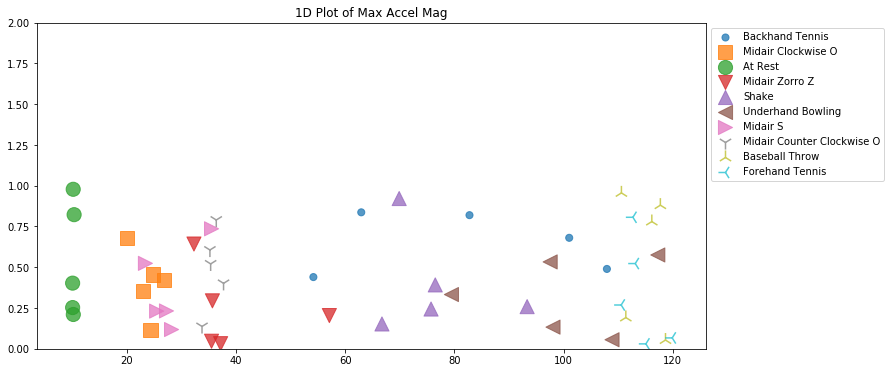

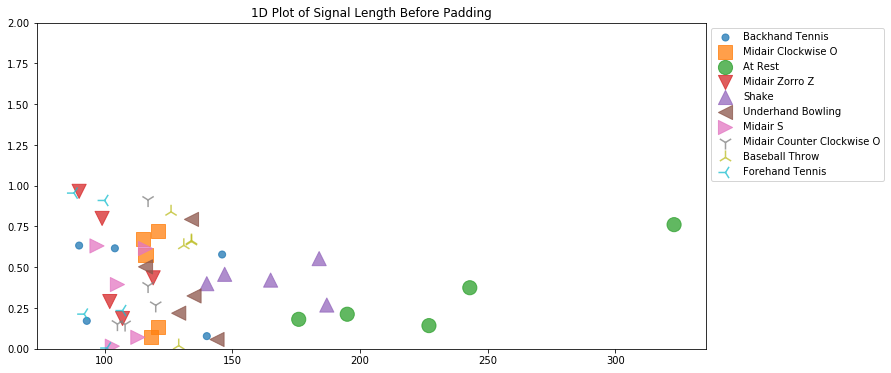

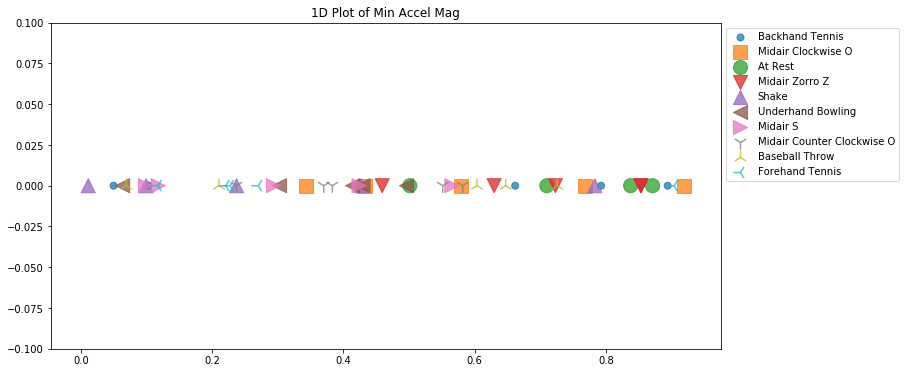

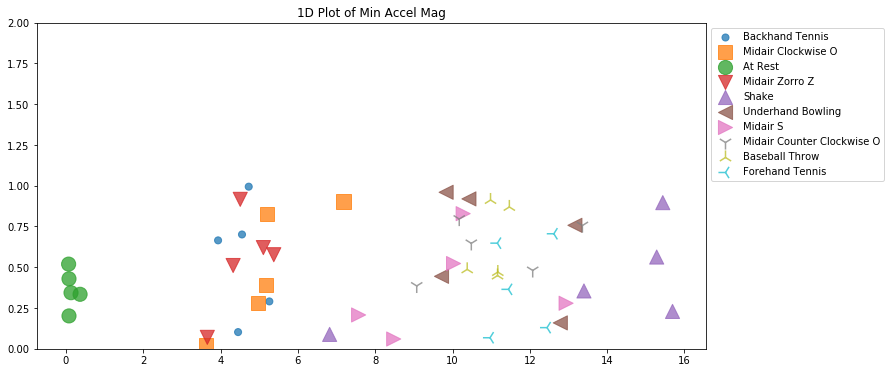

In [24]:
import itertools

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}
# Plots the maximum magnitude of each trial's acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.mag.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,2))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Accel Mag")
plt.show()


# Plots the length of each gesture trial
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.signalLengthBeforePadding for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,2))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Signal Length Before Padding")
plt.show()

# Plots the min magnitude of each trial's acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    y = list(trial.accel.mag.min() for trial in trials)
    x = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((-0.1,0.1))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Min Accel Mag")
plt.show()

# Plots the max magnitude of each trial's gyro signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.gyro.mag.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,2))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Min Accel Mag")
plt.show()

# Now explore the discriminability of 2 dimensions!
# For this exercise, you're going to explore these features in 2D by combining them. Please wait
# to complete this exercise until we get to it in class
# I purposefully did not give you skeleton code here. Please copy/paste a section from the above cell
# and adapt it to plot two features at a time in a scatter plot


In [30]:
# Now, let's try to build an SVM using some of the features you brainstormed. 
# We're going to start with the simplest possible SVM using only one feature
# 
# Some nice resources:
#  - Official sci-kit learn (Start here!): http://scikit-learn.org/stable/modules/svm.html
#  - A simple classification example using scikit: https://dbaumgartel.wordpress.com/2014/03/10/a-scikit-learn-example-in-10-lines/
#  - A nice video overview of SVM: https://youtu.be/N1vOgolbjSc
#  
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(mymapGestureToTrials)
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials)
    
gestureNames = list(mapGestureToTrials.keys())

# now build an SVM
# Currently training on folds 1-4 and testing on fold 0 (just for now)
foldIndex = 0
mapGestureNameToCorrectMatchCnt = dict()
mapGestureNameToPredictionResultList = dict()
trainingData = np.array([])
classLabels = np.array([])

# # Append training data of folds 1-4 
# for i in range(1, numFolds):
#     # print("\tFold: ", i)
#     fold = foldToMapGestureToTrial[i]
#     for gestureName, trial in fold.items():
#         trainingData = np.append(trainingData, trial.accel.mag.max())
#         classLabels = np.append(classLabels, trial.gestureName)

# # for row in range(0,len(classLabels)):
# #     print("gestureName={} values={}".format(classLabels[row], trainingData[row]))
        
# # Setup SVM
# trainingData = trainingData.reshape(-1, 1) # for 1D input feature vectors, we have to reshape like this

# # Traing our SVM
# #print(trainingData)
# clf = svm.SVC()
# clf.fit(trainingData, classLabels) 

# predict=[]

# # Test our SVM
# # fold 0 will be our test fold
# testFold = foldToMapGestureToTrial[0]
# for gestureName, trial in testFold.items():
#     print("Attempting to predict: {}".format(gestureName))
#     svmPrediction = clf.predict(trial.accel.mag.max())
#     predict.append(svmPrediction)
#     print("SVM prediction: {}".format(svmPrediction[0]))
    
###  #######################3  
for d in range(0,5):
    testFold = foldToMapGestureToTrial[d]
    for x in range(0,5):
        if x!=d:
            fold = foldToMapGestureToTrial[x]
            for gestureName, trial in fold.items():
                trainingData = np.append(trainingData, trial.accel.mag.max())
                classLabels = np.append(classLabels, trial.gestureName)

    # for row in range(0,len(classLabels)):
    #     print("gestureName={} values={}".format(classLabels[row], trainingData[row]))

    # Setup SVM
            trainingData = trainingData.reshape(-1, 1) # for 1D input feature vectors, we have to reshape like this

    # Traing our SVM
            clf = svm.SVC()
            clf.fit(trainingData, classLabels) 

#             predict=[]
#             for gestureName, trial in testFold.items():
#                 print("Attempting to predict: {}".format(gestureName))
#                 svmPrediction = clf.predict(trial.accel.mag.max())
#                 predict.append(svmPrediction)
#                 print("SVM prediction: {}".format(svmPrediction[0]))

# ###
    
# print("the overall accuracy is :",accuracy_score(gestureNames,predict))

# print("The confusion matrix is :",confusion_matrix(gestureNames,predict))

In [31]:
# Here's some sample code for building up a multi-dimensional feature vector
# Feel free to use this approach (or not) in your homework

# Example create_feature_vector function that returns a 3D feature vector for the given trial   
import random
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report


def create_feature_vector(trial):
    return [trial.accel.mag.max(), trial.accel.signalLengthBeforePadding, trial.gyro.mag.max(),trial.accel.mag.min(),trial.gyro.x.max(),trial.gyro.y.max(),trial.accel.x.max(),trial.accel.z.max()]
    
# takes in the current testFold, the trainingFolds, and a create_feature_vector function
# the create_feature_vector function creates feature vectors given a Trial object
# I suggest creating multiple different create_feature_vector functions that you pass
# in here and test (this will allow you to easily compare different feature vectors)

def get_svm_input(testFold, trainingFolds, create_feature_vector):
    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)

    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(list(trainingFolds[0].values()))
    numFeatures = len(create_feature_vector(tmpTrainingTrial))
    print("The feature vector size is: {}".format(numFeatures))

    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature
    trainingData = np.zeros([numOfTrainingTrials, numFeatures])
    trainingTrials = list()
    trainingLabels = np.array([])

    # Build up the training data and also keep track of the class labels (in trainingLabels)
    row = 0
    for trainingFold in trainingFolds:
        for trainingGestureName, trainingTrial in trainingFold.items():
            trainingData[row] = create_feature_vector(trainingTrial)
            trainingLabels = np.append(trainingLabels, trainingTrial.gestureName)
            trainingTrials.append(trainingTrial)
            row = row + 1

    # Now setup the testData data structure
    testData = np.zeros([len(testFold), numFeatures])
    testRow = 0
    groundtruthLabels = list()
    testTrials = list()
    for testGestureName, testTrial in testFold.items():
        testTrials.append(testTrial)
        testData[testRow] = create_feature_vector(testTrial)
        groundtruthLabels.append(testGestureName)
        testRow = testRow + 1
    return (trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials)

# This is an example of how you would call the get_svm_input method
# You'll have to figure out how to appropriately put this in a for loop and use it...  

for i in range(0,5):
    print("Test Fold",i+1)
    trainingFolds = []
    testFold = foldToMapGestureToTrial[i]
    for x in range(0,5):
        if x!=i :
            trainingFolds = trainingFolds+[foldToMapGestureToTrial[x]]


    svmInput = get_svm_input(testFold,  trainingFolds, create_feature_vector)

    # Unpack the tuple into more semantic variable names
    trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials = svmInput

    classLabels2 = np.array([])
    for i in range(0, 4):
        fold = foldToMapGestureToTrial[i]
        for gestureName, trial in fold.items():
    #         trainingData = np.append(trainingData, trial.accel.mag.max())
            classLabels2 = np.append(classLabels2, trial.gestureName)
    # print(classLabels2)

    # Traing our SVM
    # print(trainingData)
    clf1 = svm.SVC()
    clf1.fit(trainingData, classLabels2) 

    predict2=[]
    # Test our SVM
    # fold 0 will be our test fold
    testFold = foldToMapGestureToTrial[0]
    for gestureName, trial in testFold.items():
        print("Attempting to predict: {}".format(gestureName))
        svmPrediction = clf.predict(trial.accel.mag.max())
        predict2.append(svmPrediction)
        print("SVM prediction: {}".format(svmPrediction[0]))

        
a=np.asarray(gestureNames)
b=np.asarray(predict2)

print("the overall accuracy for SVM is :",accuracy_score(gestureNames,predict2))

print("The confusion matrix for SVM is :",confusion_matrix(a,b))


print(classification_report(a,b))


        

Test Fold 1
The feature vector size is: 8
Attempting to predict: Backhand Tennis
SVM prediction: Backhand Tennis
Attempting to predict: Midair Clockwise O
SVM prediction: Midair Clockwise O
Attempting to predict: At Rest
SVM prediction: At Rest
Attempting to predict: Midair Zorro Z
SVM prediction: Midair Zorro Z
Attempting to predict: Shake
SVM prediction: Shake
Attempting to predict: Underhand Bowling
SVM prediction: Underhand Bowling
Attempting to predict: Midair S
SVM prediction: Midair S
Attempting to predict: Midair Counter Clockwise O
SVM prediction: Midair Counter Clockwise O
Attempting to predict: Baseball Throw
SVM prediction: Baseball Throw
Attempting to predict: Forehand Tennis
SVM prediction: Forehand Tennis
Test Fold 2
The feature vector size is: 8
Attempting to predict: Backhand Tennis
SVM prediction: Backhand Tennis
Attempting to predict: Midair Clockwise O
SVM prediction: Midair Clockwise O
Attempting to predict: At Rest
SVM prediction: At Rest
Attempting to predict: Mi

In [27]:
numFolds = get_min_num_of_trials(allmymapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(allmymapGestureToTrials)
foldToMapGestureToTrial = generate_kfolds(allmymapGestureToTrials)
    
gestureNames = list(allmymapGestureToTrials.keys())

# now build an SVM
# Currently training on folds 1-4 and testing on fold 0 (just for now)
foldIndex = 0
mapGestureNameToCorrectMatchCnt = dict()
mapGestureNameToPredictionResultList = dict()
trainingData = np.array([])
classLabels = np.array([])


for d in range(0,5):
    testFold = myfoldToMapGestureToTrial[d]
    for x in range(0,5):
        if x!=d:
            fold = myfoldToMapGestureToTrial[x]
            for gestureName, trial in fold.items():
                trainingData = np.append(trainingData, trial.accel.mag.max())
                classLabels = np.append(classLabels, trial.gestureName)

    # for row in range(0,len(classLabels)):
    #     print("gestureName={} values={}".format(classLabels[row], trainingData[row]))

    # Setup SVM
            trainingData = trainingData.reshape(-1, 1) # for 1D input feature vectors, we have to reshape like this

    # Traing our SVM
            clf0 = svm.SVC()
            clf0.fit(trainingData, classLabels) 

In [28]:
# Here's some sample code for building up a multi-dimensional feature vector
# Feel free to use this approach (or not) in your homework

# Example create_feature_vector function that returns a 3D feature vector for the given trial   
import random
def create_feature_vector(trial):
    return [trial.accel.mag.max(), trial.accel.signalLengthBeforePadding, trial.gyro.mag.max(),trial.accel.mag.min(),trial.gyro.x.max(),trial.gyro.y.max(),trial.accel.x.max(),trial.accel.z.max()]
    
# takes in the current testFold, the trainingFolds, and a create_feature_vector function
# the create_feature_vector function creates feature vectors given a Trial object
# I suggest creating multiple different create_feature_vector functions that you pass
# in here and test (this will allow you to easily compare different feature vectors)

def get_svm_input(testFold, trainingFolds, create_feature_vector):

    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)

    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(list(trainingFolds[0].values()))
    numFeatures = len(create_feature_vector(tmpTrainingTrial))
    print("The feature vector size is: {}".format(numFeatures))

    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature
    trainingData = np.zeros([numOfTrainingTrials, numFeatures])
    trainingTrials = list()
    trainingLabels = np.array([])

    # Build up the training data and also keep track of the class labels (in trainingLabels)
    row = 0
    for trainingFold in trainingFolds:
        for trainingGestureName, trainingTrial in trainingFold.items():
            trainingData[row] = create_feature_vector(trainingTrial)
            trainingLabels = np.append(trainingLabels, trainingTrial.gestureName)
            trainingTrials.append(trainingTrial)
            row = row + 1

    # Now setup the testData data structure
    testData = np.zeros([len(testFold), numFeatures])
    testRow = 0
    groundtruthLabels = list()
    testTrials = list()
    for testGestureName, testTrial in testFold.items():
        testTrials.append(testTrial)
        testData[testRow] = create_feature_vector(testTrial)
        groundtruthLabels.append(testGestureName)
        testRow = testRow + 1
        
    return (trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials)

# This is an example of how you would call the get_svm_input method
# You'll have to figure out how to appropriately put this in a for loop and use it...  

for i in range(0,5):
    print("Test Fold",i+1)
    trainingFolds = []
    testFold = myfoldToMapGestureToTrial[i]
    for x in range(0,5):
        if x!=i :
            trainingFolds = trainingFolds+[myfoldToMapGestureToTrial[x]]

    svmInput = get_svm_input(testFold,  trainingFolds, create_feature_vector)

    # Unpack the tuple into more semantic variable names
    trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials = svmInput

    classLabels2 = np.array([])
    for i in range(0, 4):
        fold = myfoldToMapGestureToTrial[i]
        for gestureName, trial in fold.items():
    #         trainingData = np.append(trainingData, trial.accel.mag.max())
            classLabels2 = np.append(classLabels2, trial.gestureName)
    # print(classLabels2)

    # Traing our SVM
    # print(trainingData)
    clf1 = svm.SVC()
    clf1.fit(trainingData, classLabels2) 

    predict2=[]
    rst=[]
    

    # Test our SVM
    # fold 0 will be our test fold
    testFold = myfoldToMapGestureToTrial[0]
    for gestureName, trial in testFold.items():
        rst.append(gestureName)
        print("Attempting to predict: {}".format(gestureName))
        svmPrediction = clf0.predict(trial.accel.mag.max())
        predict2.append(svmPrediction)
        print("SVM prediction: {}".format(svmPrediction[0]))


print("the overall accuracy for SVM is :",accuracy_score(rst,predict2))

print("The confusion matrix for SVM is :",confusion_matrix(rst,predict2))

a=np.asarray(gestureNames)
b=np.asarray(predict2)
print(classification_report(a,b))

Test Fold 1
The feature vector size is: 8
Attempting to predict: Forehand Tennis
SVM prediction: Backhand Tennis
Attempting to predict: Midair Zorro Z
SVM prediction: Midair Zorro Z
Attempting to predict: Midair Counter Clockwise O
SVM prediction: Midair Counter Clockwise O
Attempting to predict: Midair S
SVM prediction: Midair Counter Clockwise O
Attempting to predict: At Rest
SVM prediction: At Rest
Attempting to predict: Backhand Tennis
SVM prediction: Forehand Tennis
Attempting to predict: Baseball Throw
SVM prediction: Baseball Throw
Attempting to predict: Midair Clockwise O
SVM prediction: Midair Clockwise O
Attempting to predict: Underhand Bowling
SVM prediction: Underhand Bowling
Attempting to predict: Shake
SVM prediction: Shake
Attempting to predict: Your Custom Gesture
SVM prediction: Your Custom Gesture
Test Fold 2
The feature vector size is: 8
Attempting to predict: Forehand Tennis
SVM prediction: Backhand Tennis
Attempting to predict: Midair Zorro Z
SVM prediction: Midair

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

x = np.array(trainingData)
y = np.array(testData)
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

2070.0867405658482


In [ ]:
#Should use for loop on all distance to find the closest oen - which is the prediction gesture